In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# For progress bars
from tqdm.notebook import tqdm

# Setting plot style
sns.set(style="whitegrid")
%matplotlib inline


In [2]:
# Define the base directory for Malaria dataset
base_dir = '/kaggle/input/cell-images-for-detecting-malaria/cell_images'

# Define class names for classification
classes = ['Parasitized', 'Uninfected']


In [3]:
# Initialize lists to hold image paths and labels
image_paths = []
labels = []

# Populate lists with image paths and labels
for cls in classes:
    class_dir = os.path.join(base_dir, cls)
    for img_filename in os.listdir(class_dir):
        image_paths.append(os.path.join(class_dir, img_filename))
        labels.append(cls)

# Map class names to integer labels
label_mapping = {cls: idx for idx, cls in enumerate(classes)}
mapped_data = [(img, label_mapping[cls]) for img, cls in zip(image_paths, labels)]

# Convert to DataFrame for inspection
mapped_df = pd.DataFrame(mapped_data, columns=['image_path', 'label'])
print("Sample data:")
print(mapped_df.head())
print(f"Total images: {len(mapped_df)}")


Sample data:
                                          image_path  label
0  /kaggle/input/cell-images-for-detecting-malari...      0
1  /kaggle/input/cell-images-for-detecting-malari...      0
2  /kaggle/input/cell-images-for-detecting-malari...      0
3  /kaggle/input/cell-images-for-detecting-malari...      0
4  /kaggle/input/cell-images-for-detecting-malari...      0
Total images: 27560


In [4]:
from PIL import UnidentifiedImageError

class MalariaCellDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = [img for img in image_paths if img.endswith(('.png', '.jpg', '.jpeg'))]  # Only keep valid image files
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            # Load image
            image = Image.open(self.image_paths[idx]).convert('RGB')
            
            # Apply transformations
            if self.transform:
                image = self.transform(image)
                
            label = self.labels[idx]
            return image, label
        
        except UnidentifiedImageError:
            # Skip unreadable files and proceed to the next item
            print(f"Skipping unreadable file: {self.image_paths[idx]}")
            return self.__getitem__((idx + 1) % len(self))  # Use modulo to prevent index out of range


In [5]:
# Define image transformations for training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define transformations for validation and testing
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [6]:
# Define split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Calculate split sizes
total_size = len(mapped_data)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

print(f"Total samples: {total_size}")
print(f"Training samples: {train_size}")
print(f"Validation samples: {val_size}")
print(f"Testing samples: {test_size}")

# Shuffle and split data
from sklearn.model_selection import train_test_split

# First split: Train and Temp (Val + Test)
train_data, temp_data = train_test_split(
    mapped_data,
    test_size=(1 - train_ratio),
    random_state=42,
    stratify=[x[1] for x in mapped_data]  # Stratify based on labels
)

# Second split: Validation and Test
val_size_adjusted = val_ratio / (val_ratio + test_ratio)  # Adjust validation size
val_data, test_data = train_test_split(
    temp_data,
    test_size=(1 - val_size_adjusted),
    random_state=42,
    stratify=[x[1] for x in temp_data]
)

# Separate paths and labels for each set
train_paths, train_labels = zip(*train_data)
val_paths, val_labels = zip(*val_data)
test_paths, test_labels = zip(*test_data)

print(f"Training samples: {len(train_paths)}")
print(f"Validation samples: {len(val_paths)}")
print(f"Testing samples: {len(test_paths)}")

# Compute class weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights = torch.tensor(class_weights, dtype=torch.float)
print(f"Class Weights: {class_weights}")


Total samples: 27560
Training samples: 19292
Validation samples: 4134
Testing samples: 4134
Training samples: 19291
Validation samples: 4134
Testing samples: 4135
Class Weights: tensor([1.0001, 0.9999])


In [7]:
# Create Dataset instances
train_dataset = MalariaCellDataset(train_paths, train_labels, transform=train_transform)
val_dataset = MalariaCellDataset(val_paths, val_labels, transform=val_test_transform)
test_dataset = MalariaCellDataset(test_paths, test_labels, transform=val_test_transform)

# Define batch size and number of workers
batch_size = 32
num_workers = 4

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

print(f"Number of batches - Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")


Number of batches - Train: 603, Val: 130, Test: 130


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


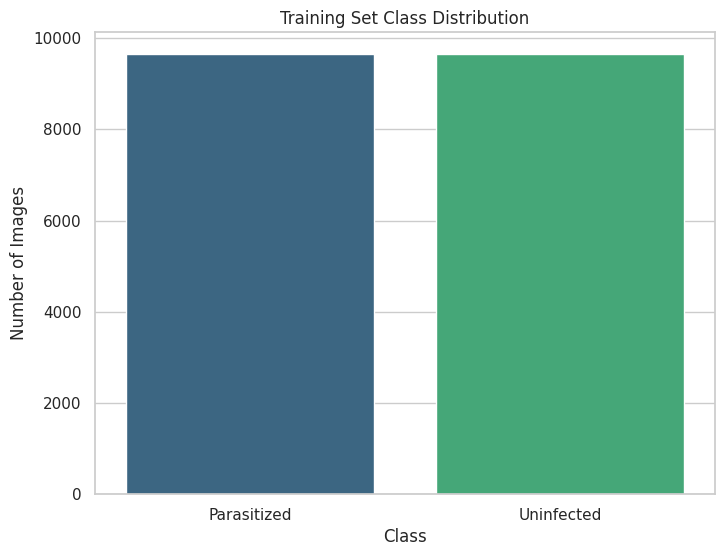

In [8]:
# Count class distribution in training set
train_label_counts = pd.Series(train_labels).value_counts().sort_index()

# Create a bar plot for class distribution
plt.figure(figsize=(8,6))
sns.barplot(x=classes, y=train_label_counts.values, palette='viridis')
plt.title('Training Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


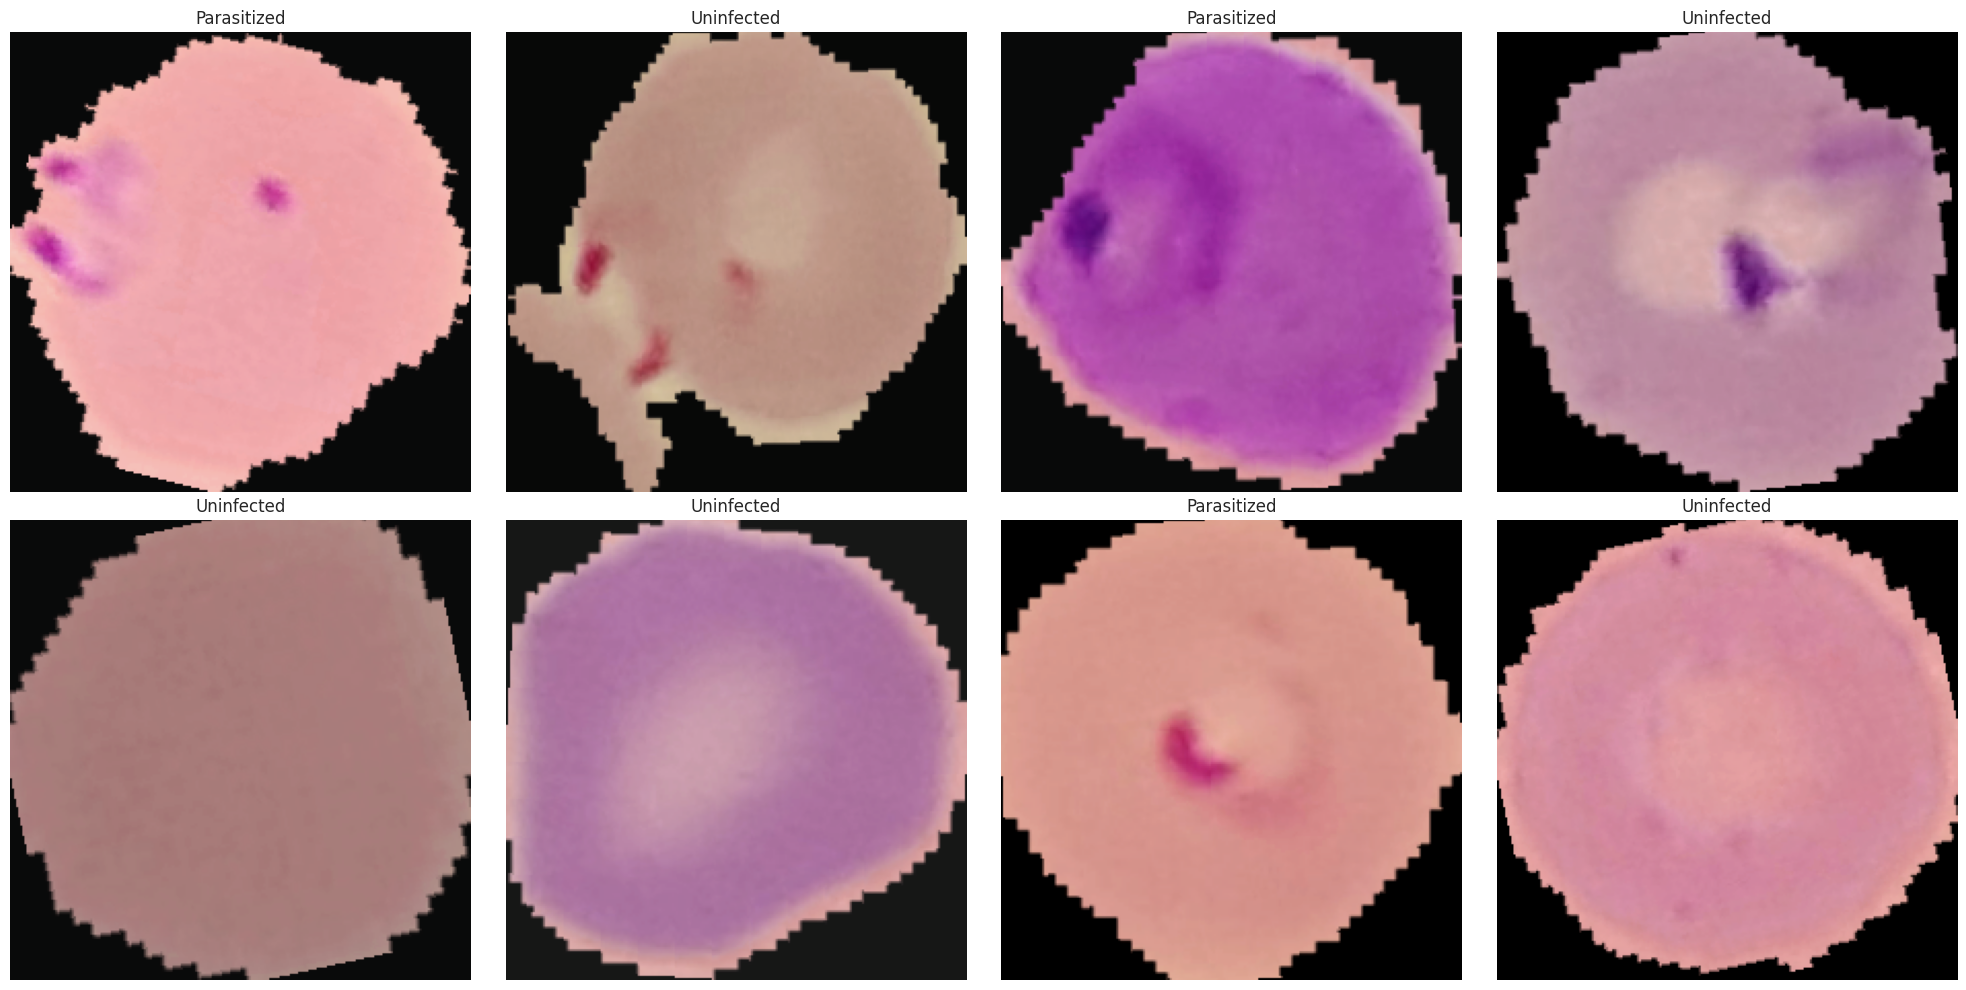

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def imshow(img, title=None):
    """
    Displays a tensor as an image.
    
    Args:
        img (Tensor): Image tensor.
        title (str, optional): Title for the image.
    """
    img = img.numpy().transpose((1, 2, 0))
    img = np.clip(img * np.array([0.229, 0.224, 0.225]) + 
                 np.array([0.485, 0.456, 0.406]), 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

def show_batch(loader, classes, num_images=8):
    """
    Displays a batch of images with their labels.
    
    Args:
        loader (DataLoader): DataLoader to fetch the batch.
        classes (list): List of class names.
        num_images (int): Number of images to display.
    """
    images, labels = next(iter(loader))
    
    # Calculate grid dimensions
    num_rows = (num_images + 3) // 4  # Ensure enough rows for `num_images`
    plt.figure(figsize=(20, num_rows * 5))
    
    for i in range(num_images):
        plt.subplot(num_rows, 4, i + 1)  # Arrange images in a `num_rows x 4` grid
        imshow(images[i])
        plt.title(classes[labels[i].item()])
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Show a batch from the training set
show_batch(train_loader, classes, num_images=8)


In [10]:
class ResNet50Baseline(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50Baseline, self).__init__()
        self.resnet = models.resnet50(pretrained=False)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)
    
    def forward(self, x):
        x = self.resnet(x)
        return x


In [11]:
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class ResNet50WithSE(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50WithSE, self).__init__()
        self.resnet = models.resnet50(pretrained=False)
        self.se = SEBlock(channel=2048, reduction=16)  # Applied to layer4
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)
    
    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)
        
        x = self.se(x)
        
        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.resnet.fc(x)
        return x


In [12]:
class ECABlock(nn.Module):
    def __init__(self, in_channels, gamma=2, b=1):
        super(ECABlock, self).__init__()
        k = int(abs((torch.log2(torch.tensor(in_channels, dtype=torch.float32)) + b) / gamma))
        k = k if k % 2 else k + 1
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(in_channels, in_channels, kernel_size=k, padding=(k - 1) // 2, groups=in_channels, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y = self.avg_pool(x)
        y = y.squeeze(-1).squeeze(-1)
        y = y.unsqueeze(1)
        y = self.conv(y).squeeze(1).unsqueeze(-1).unsqueeze(-1)
        y = self.sigmoid(y)
        return x * y.expand_as(x)

class ResNet50WithECA(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50WithECA, self).__init__()
        self.resnet = models.resnet50(pretrained=False)
        self.eca = ECABlock(in_channels=2048)  # Applied to layer4
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)
        
        x = self.eca(x)
        
        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.resnet.fc(x)
        return x


In [13]:
class GCTBlock(nn.Module):
    def __init__(self, in_channels, epsilon=1e-5, use_relu=True):
        super(GCTBlock, self).__init__()
        self.alpha = nn.Parameter(torch.zeros(1, in_channels, 1, 1))
        self.gamma = nn.Parameter(torch.ones(1, in_channels, 1, 1))
        self.epsilon = epsilon
        self.use_relu = use_relu

    def forward(self, x):
        norm = torch.sqrt(x.pow(2).mean(dim=(2, 3), keepdim=True) + self.epsilon)
        y = self.alpha * x / norm
        if self.use_relu:
            y = nn.functional.relu(y)
        return self.gamma * y + x

class ResNet50WithGCT(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50WithGCT, self).__init__()
        self.resnet = models.resnet50(pretrained=False)
        self.gct = GCTBlock(in_channels=2048)  # Applied to layer4
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)
        
        x = self.gct(x)
        
        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.resnet.fc(x)
        return x


In [14]:
import torch.fft as fft

class FcaNetBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(FcaNetBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction),
            nn.ReLU(),
            nn.Linear(in_channels // reduction, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        y = fft.fft2(x)
        y = torch.abs(y).mean(dim=(2, 3), keepdim=True)
        y = self.fc(y.view(x.size(0), -1)).view(x.size(0), x.size(1), 1, 1)
        return x * y.expand_as(x)

class ResNet50WithFcaNet(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50WithFcaNet, self).__init__()
        self.resnet = models.resnet50(pretrained=False)
        self.fca = FcaNetBlock(in_channels=2048)  # Applied to layer4
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)
        
        x = self.fca(x)
        
        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.resnet.fc(x)
        return x


In [15]:
import torch
import torch.nn as nn
from torchvision import models

class SplitAttn(nn.Module):
    def __init__(self, in_channels, radix=2):
        super(SplitAttn, self).__init__()
        self.radix = radix
        self.in_channels = in_channels

        # Ensure `in_channels` is divisible by `radix`
        if in_channels % radix != 0:
            raise ValueError(f"in_channels ({in_channels}) must be divisible by radix ({radix})")

        # Create grouped convolution layer for split attention
        self.conv = nn.Conv2d(in_channels, in_channels * radix, kernel_size=3, padding=1, groups=radix, bias=False)
        self.rsoftmax = nn.Softmax(dim=1)

    def forward(self, x):
        batch, channels, height, width = x.size()
        
        # Apply grouped convolution, expanding to (radix * in_channels)
        x = self.conv(x)
        
        # Reshape to separate radix groups, check that radix groups align with input dimensions
        try:
            x = x.view(batch, self.radix, channels, height, width).sum(dim=1)
        except RuntimeError as e:
            raise RuntimeError(f"Error in reshaping: {e}\n"
                               f"Expected shape: {[batch, self.radix, channels, height, width]}\n"
                               f"Got shape: {x.shape}")
        
        # Apply softmax over the channel dimension for attention scaling
        x = self.rsoftmax(x)
        return x

class ResNet50WithSplitAttention(nn.Module):
    def __init__(self, num_classes=2, pretrained=False):
        super(ResNet50WithSplitAttention, self).__init__()
        # Load ResNet50 model without pretrained weights
        self.resnet = models.resnet50(pretrained=pretrained)
        # Add the Split Attention block after layer4, with input channels set to 2048
        self.split_attn = SplitAttn(in_channels=2048)
        # Replace the fully connected layer to match the number of classes
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        # Pass input through ResNet layers
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)
        
        # Apply Split Attention block
        x = self.split_attn(x)
        
        # Pass through average pooling, flatten, and final fully connected layer
        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.resnet.fc(x)
        return x


In [16]:
# Define model type options: 'baseline', 'se', 'eca', 'gct', 'fcanet', 'dianet'
model_type = 'splitattn'  # Options: 'baseline', 'se', 'eca', 'gct', 'fcanet', 'dianet'

# Number of classes
num_classes = len(classes)

# Model selection based on model_type
if model_type == 'baseline':
    model = ResNet50Baseline(num_classes=num_classes)
elif model_type == 'se':
    model = ResNet50WithSE(num_classes=num_classes)
elif model_type == 'eca':
    model = ResNet50WithECA(num_classes=num_classes)
elif model_type == 'gct':
    model = ResNet50WithGCT(num_classes=num_classes)
elif model_type == 'fcanet':
    model = ResNet50WithFcaNet(num_classes=num_classes)
elif model_type == 'dianet':
    model = ResNet50WithDIANet(num_classes=num_classes)
elif model_type == 'splitattn':
    model = ResNet50WithSplitAttention(num_classes=num_classes)
else:
    raise ValueError("Invalid model type selected.")

# Move the model to the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(model)

# Define loss function with class weights
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Define learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet50WithSplitAttention(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequ

In [17]:
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=25):
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in tqdm(dataloader, desc=phase.capitalize()):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
        
        print()
    
    print(f'Best Validation Acc: {best_acc:.4f}')
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

# Define number of epochs
num_epochs = 25

# Train the model
trained_model, history = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=num_epochs)


Epoch 1/25
----------


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Train Loss: 0.6932 Acc: 0.4996


Val:   0%|          | 0/130 [00:00<?, ?it/s]

Val Loss: 0.6931 Acc: 0.5000

Epoch 2/25
----------


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Train Loss: 0.6932 Acc: 0.4983


Val:   0%|          | 0/130 [00:00<?, ?it/s]

Val Loss: 0.6931 Acc: 0.5000

Epoch 3/25
----------


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Train Loss: 0.6932 Acc: 0.4964


Val:   0%|          | 0/130 [00:00<?, ?it/s]

Val Loss: 0.6931 Acc: 0.5000

Epoch 4/25
----------


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Train Loss: 0.6932 Acc: 0.4954


Val:   0%|          | 0/130 [00:00<?, ?it/s]

Val Loss: 0.6931 Acc: 0.5000

Epoch 5/25
----------


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Train Loss: 0.6932 Acc: 0.4947


Val:   0%|          | 0/130 [00:00<?, ?it/s]

Val Loss: 0.6931 Acc: 0.5000

Epoch 6/25
----------


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Train Loss: 0.6932 Acc: 0.4961


Val:   0%|          | 0/130 [00:00<?, ?it/s]

Val Loss: 0.6931 Acc: 0.5000

Epoch 7/25
----------


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Train Loss: 0.6932 Acc: 0.4971


Val:   0%|          | 0/130 [00:00<?, ?it/s]

Val Loss: 0.6931 Acc: 0.5000

Epoch 8/25
----------


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Train Loss: 0.6932 Acc: 0.4976


Val:   0%|          | 0/130 [00:00<?, ?it/s]

Val Loss: 0.6931 Acc: 0.5000

Epoch 9/25
----------


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Train Loss: 0.6932 Acc: 0.4974


Val:   0%|          | 0/130 [00:00<?, ?it/s]

Val Loss: 0.6931 Acc: 0.5000

Epoch 10/25
----------


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Train Loss: 0.6932 Acc: 0.4945


Val:   0%|          | 0/130 [00:00<?, ?it/s]

Val Loss: 0.6931 Acc: 0.5000

Epoch 11/25
----------


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Train Loss: 0.6931 Acc: 0.5000


Val:   0%|          | 0/130 [00:00<?, ?it/s]

Val Loss: 0.6931 Acc: 0.5000

Epoch 12/25
----------


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Train Loss: 0.6931 Acc: 0.5000


Val:   0%|          | 0/130 [00:00<?, ?it/s]

Val Loss: 0.6931 Acc: 0.5000

Epoch 13/25
----------


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Train Loss: 0.6931 Acc: 0.5000


Val:   0%|          | 0/130 [00:00<?, ?it/s]

Val Loss: 0.6931 Acc: 0.5000

Epoch 14/25
----------


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Train Loss: 0.6931 Acc: 0.5000


Val:   0%|          | 0/130 [00:00<?, ?it/s]

Val Loss: 0.6931 Acc: 0.5000

Epoch 15/25
----------


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Train Loss: 0.6931 Acc: 0.5000


Val:   0%|          | 0/130 [00:00<?, ?it/s]

Val Loss: 0.6931 Acc: 0.5000

Epoch 16/25
----------


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Train Loss: 0.6931 Acc: 0.5000


Val:   0%|          | 0/130 [00:00<?, ?it/s]

Val Loss: 0.6931 Acc: 0.5000

Epoch 17/25
----------


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Train Loss: 0.6931 Acc: 0.5000


Val:   0%|          | 0/130 [00:00<?, ?it/s]

Val Loss: 0.6931 Acc: 0.5000

Epoch 18/25
----------


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Train Loss: 0.6931 Acc: 0.5000


Val:   0%|          | 0/130 [00:00<?, ?it/s]

Val Loss: 0.6931 Acc: 0.5000

Epoch 19/25
----------


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Train Loss: 0.6931 Acc: 0.5000


Val:   0%|          | 0/130 [00:00<?, ?it/s]

Val Loss: 0.6931 Acc: 0.5000

Epoch 20/25
----------


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Train Loss: 0.6931 Acc: 0.5000


Val:   0%|          | 0/130 [00:00<?, ?it/s]

Val Loss: 0.6931 Acc: 0.5000

Epoch 21/25
----------


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Train Loss: 0.6931 Acc: 0.5000


Val:   0%|          | 0/130 [00:00<?, ?it/s]

Val Loss: 0.6931 Acc: 0.5000

Epoch 22/25
----------


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Train Loss: 0.6931 Acc: 0.5000


Val:   0%|          | 0/130 [00:00<?, ?it/s]

Val Loss: 0.6931 Acc: 0.5000

Epoch 23/25
----------


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Train Loss: 0.6931 Acc: 0.5000


Val:   0%|          | 0/130 [00:00<?, ?it/s]

Val Loss: 0.6931 Acc: 0.5000

Epoch 24/25
----------


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Train Loss: 0.6931 Acc: 0.5000


Val:   0%|          | 0/130 [00:00<?, ?it/s]

Val Loss: 0.6931 Acc: 0.5000

Epoch 25/25
----------


Train:   0%|          | 0/603 [00:00<?, ?it/s]

Train Loss: 0.6931 Acc: 0.5000


Val:   0%|          | 0/130 [00:00<?, ?it/s]

Val Loss: 0.6931 Acc: 0.5000

Best Validation Acc: 0.5000


Testing:   0%|          | 0/130 [00:00<?, ?it/s]

Classification Report:
              precision    recall  f1-score   support

 Parasitized       0.00      0.00      0.00      2068
  Uninfected       0.50      1.00      0.67      2067

    accuracy                           0.50      4135
   macro avg       0.25      0.50      0.33      4135
weighted avg       0.25      0.50      0.33      4135



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


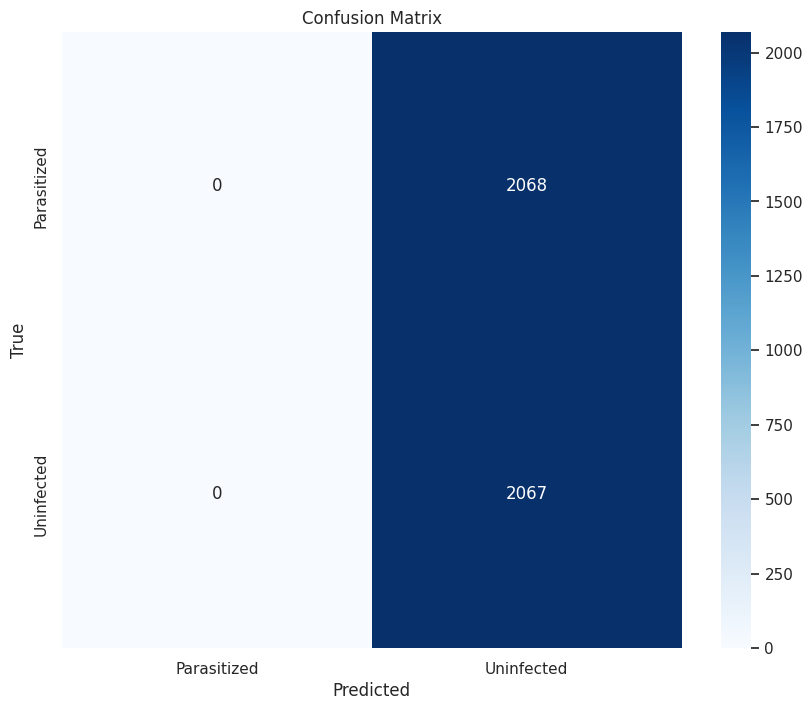

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, dataloader, classes):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Testing'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluate the model on the test set
evaluate_model(trained_model, test_loader, classes)


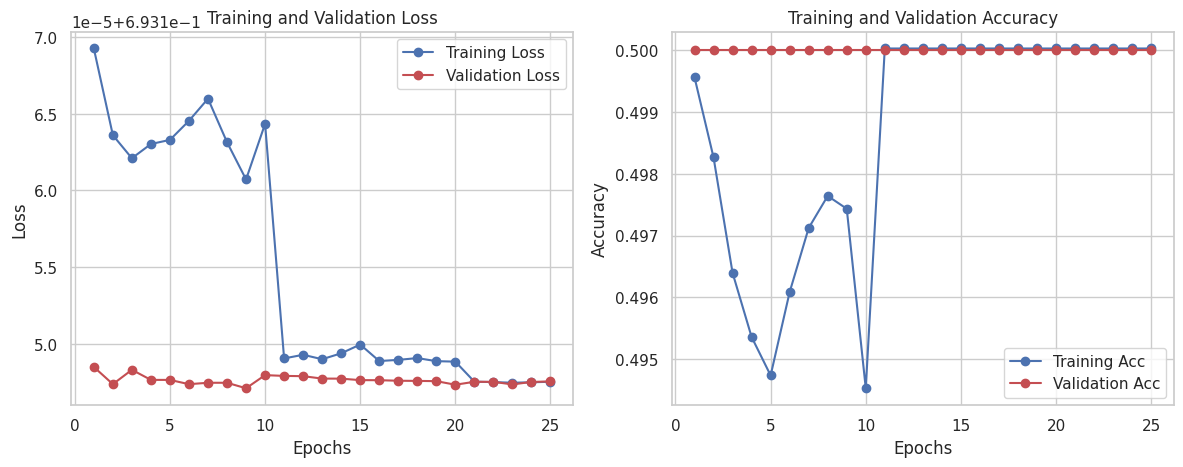

In [19]:
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Plot Loss
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, history['train_acc'], 'bo-', label='Training Acc')
    plt.plot(epochs, history['val_acc'], 'ro-', label='Validation Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_history(history)


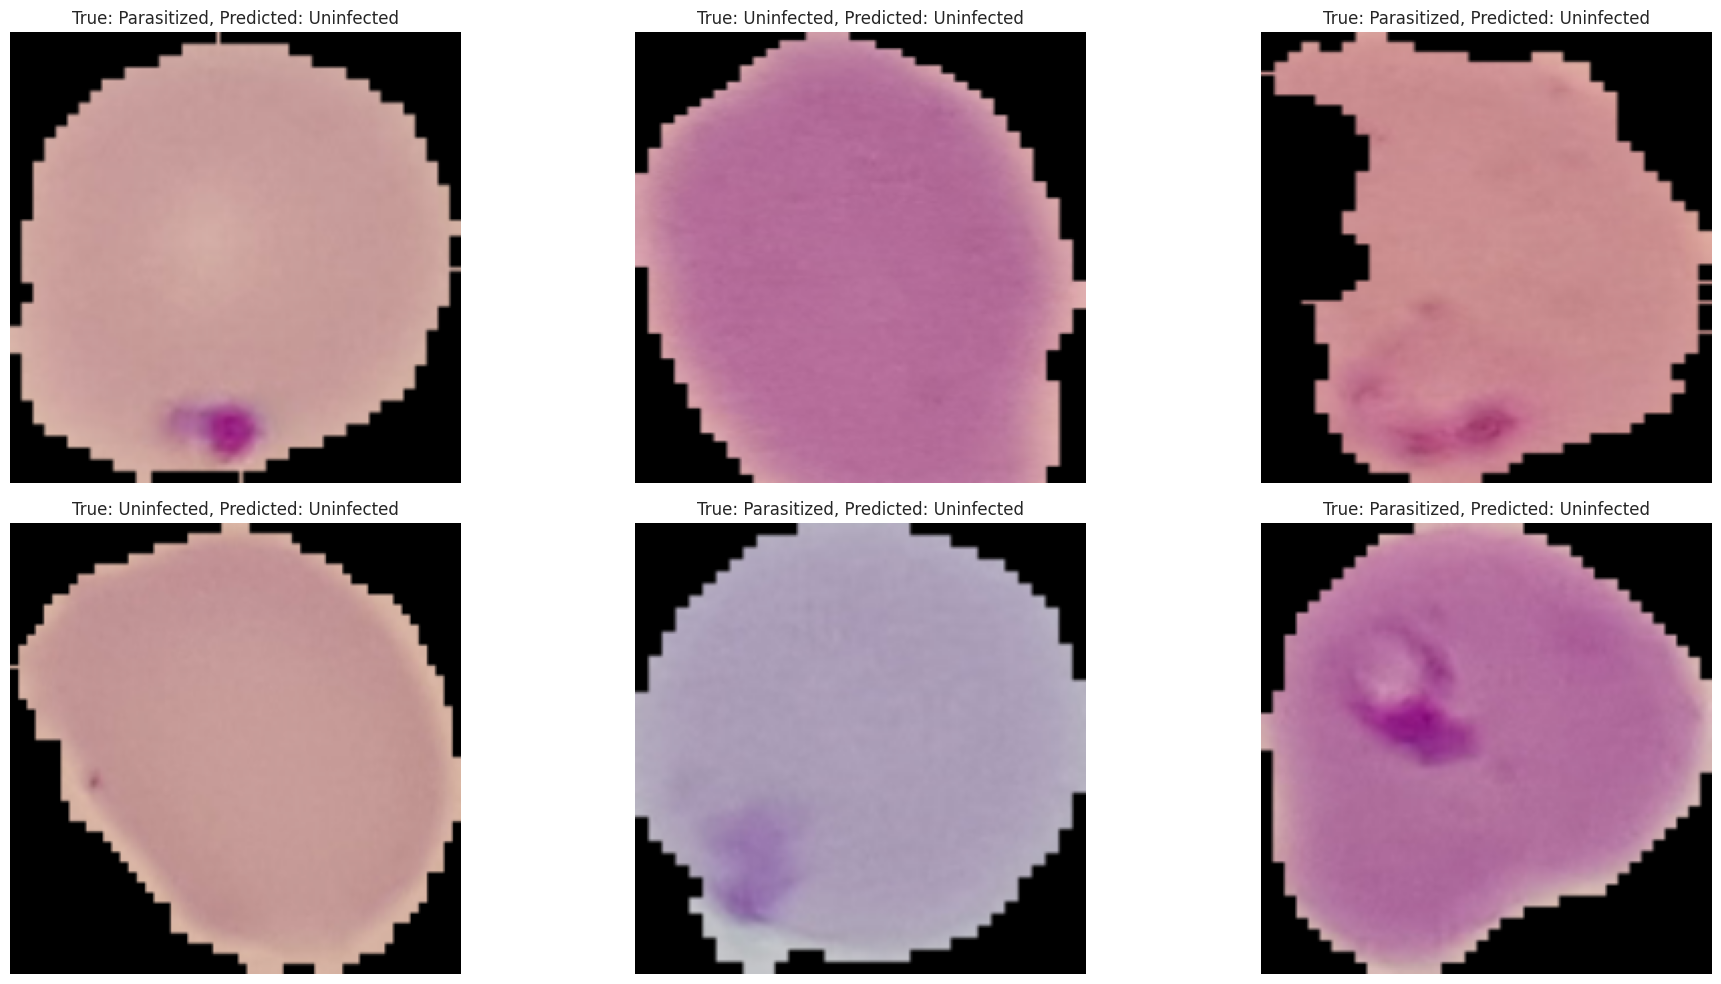

In [20]:
def visualize_predictions(model, dataloader, classes, num_images=6):
    model.eval()
    images, labels = next(iter(dataloader))
    images = images.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
    
    images = images.cpu().numpy()
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()
    
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        plt.subplot(2, num_images//2, i+1)
        img = images[i].transpose((1, 2, 0))
        img = np.clip(img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)
        plt.imshow(img)
        plt.title(f"True: {classes[labels[i]]}, Predicted: {classes[preds[i]]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize sample predictions
visualize_predictions(trained_model, test_loader, classes, num_images=6)
